# Introduction

In [42]:
# Preamble
## Imports
import os
import pandas as pd
import configparser
import sys
from io import StringIO
import missingno as msno
from IPython.display import display
import json

## Load configuration
aws_cred_filepath = os.path.join(os.path.expanduser("~"), '.aws', 'credentials')
aws_credentials = configparser.ConfigParser()
aws_credentials.read(aws_cred_filepath)
aws_access_key_id = aws_credentials.get('default', 'aws_access_key_id')
aws_secret_access_key = aws_credentials.get('default', 'aws_secret_access_key')

## Load data specs dict
with open('data/dataset_specs.json', 'r') as f:
    data_specs = json.load(f)
f.close()

The global digital advertising market is worth approximately $602 billion today. Due to the increasing rate of of online participation since the COVID-19 pandemic, this number has been rapidly increasing and is expected to reach $871 billion by the end of 2027 ([eMarketer, 2024](#eMarketer)). Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of Machine Learning research over the past through years.

Initially, shallow prediction methods such as XGBoost (Cite), Factorization Machines (Cite) and Field-Aware Factorization Machines (Cite) have been used for CTR prediction. However, these methods have often been shown to be unable to capture the higher order feature interactions in the sparse multy value categorical Ad Marketplace datasets (Cite). Since then, Deep Learning methods have been shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep Learning architechtures for click-through rate prediction

In the following report, I explore the relevant datasets and simulations that I will be using throughout my research project. In the first section, I perform an exploratory data analysis on three widely adopted benchmark CTR prediction datasets; the KDD12 ([Aden, 2012](#kdd12)), Avazu ([Wang and Cukierski, 2014](#avazu)) and Criteo ([Tien et al, 2014](#criteo)) datasets. In the second section, I then explore possible ways of simulating the ad marketplace environment in order to test the reinforcement learning framework.

# Datasets

## KDD12

The __KDD12__ dataset was first released for the KDD Cup 2012 competition (Cite), with the original task being to predict the number of clicks for a given number of impressions. Each line represents a training instance derived from the session logs for the advertizing marketplace. In the context of this dataset, a "session" refers to an interaction between a user and the search engine, containing the following components; the user, a list of adverts returned by the search engine and shown (impressed) to the user and zero or more adverts clicked on by the user. Each line in the training set therefore includes:
- __Clicks__
- __Impressions__
- __Display URL__
- __Ad ID__
- __Advertiser ID__
- __Depth__
- __Position__
- __Query ID__
- __Keyword ID__
- __Title ID__
- __Description ID__
- __User ID__

Describe each of the datasets

Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Click          int64 
 1   Impression     int64 
 2   DisplayURL     string
 3   AdID           string
 4   AdvertiserID   string
 5   Depth          int64 
 6   Position       int64 
 7   QueryID        string
 8   KeywordID      string
 9   TitleID        string
 10  DescriptionID  string
 11  UserID         string
dtypes: int64(4), string(8)


,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


<Axes: >

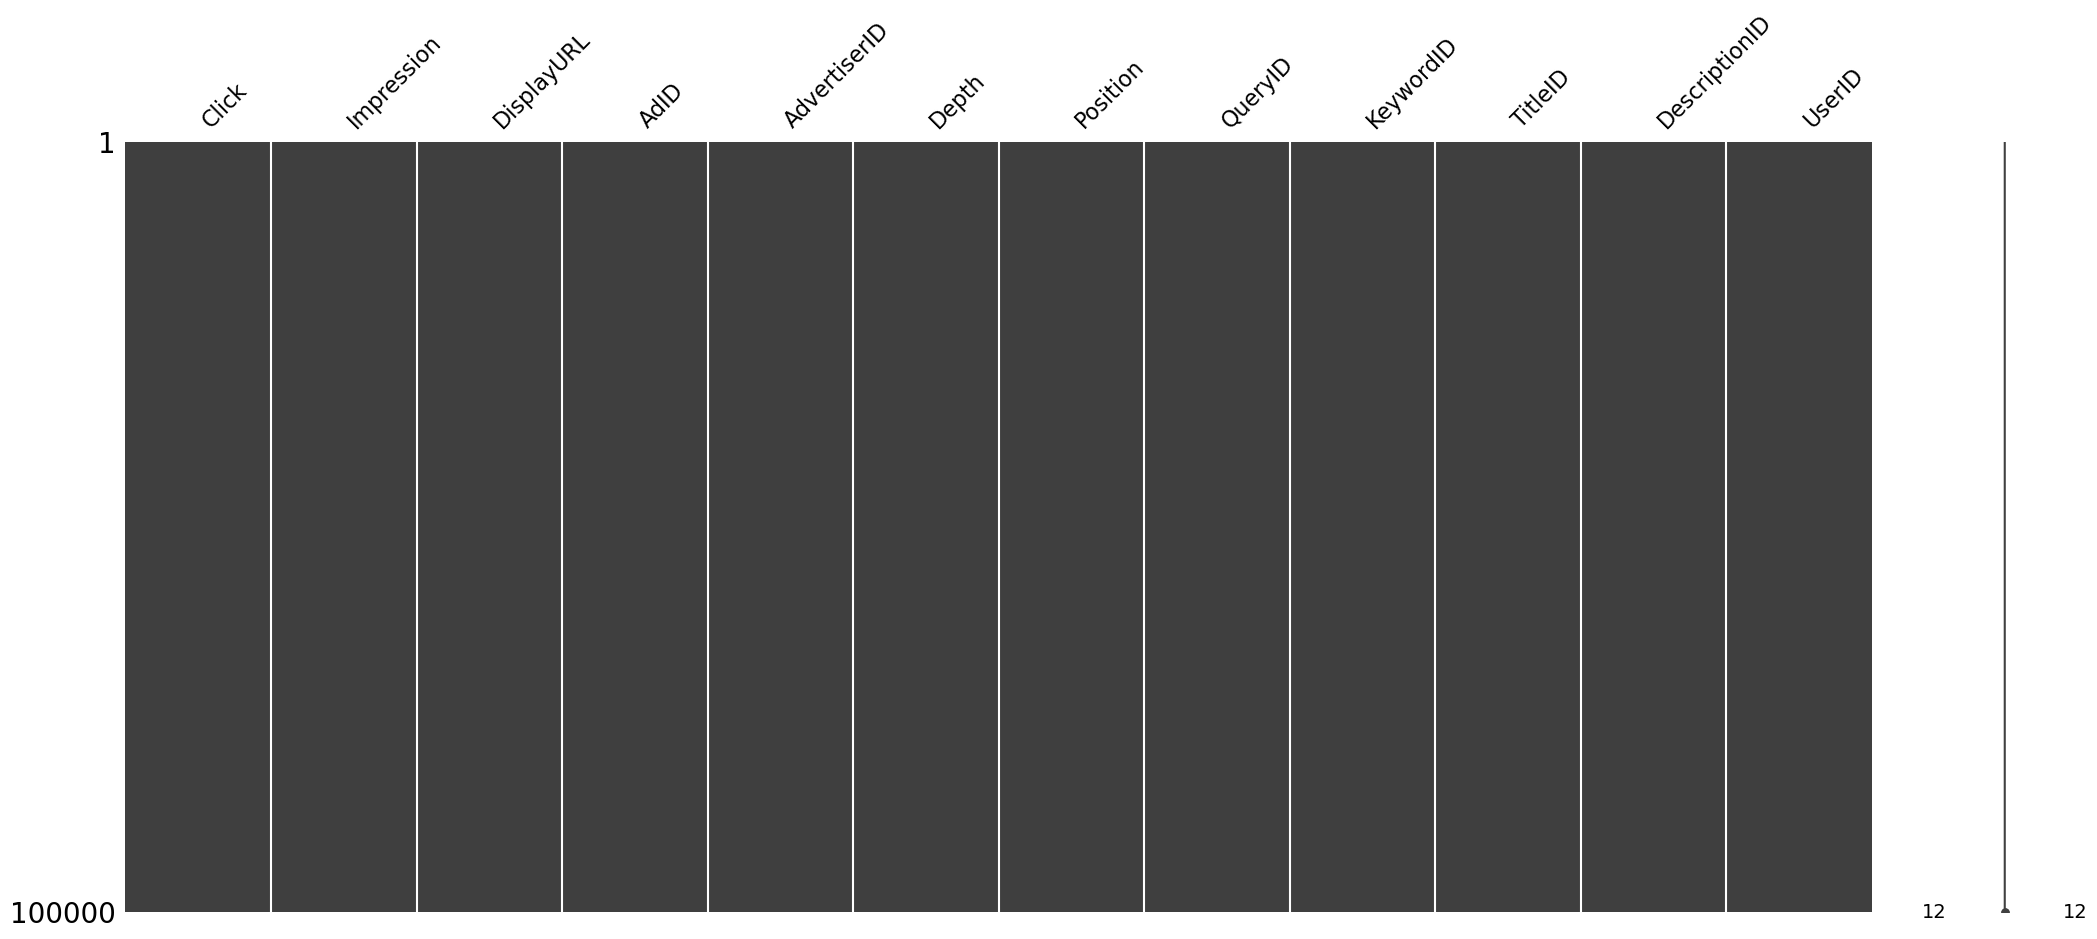

In [37]:
# Print the Column Names and Data Types of the Training Data
training_data = pd.read_csv(
    's3://mlds-final-project-bucket/kdd12/train/training/training.txt',
    delimiter='\t',
    storage_options={
        'key': aws_access_key_id,
        'secret': aws_secret_access_key
    },
    nrows = 1000,
    header=None,
    names=['Click','Impression','DisplayURL','AdID','AdvertiserID','Depth','Position','QueryID','KeywordID','TitleID','DescriptionID','UserID'],
    dtype={
        'Click': 'int64',
        'Impression': 'int64',
        'DisplayURL': 'string',
        'AdID': 'string',
        'AdvertiserID': 'string',
        'Depth': 'int64',
        'Position': 'int64',
        'QueryID': 'string',
        'KeywordID': 'string',
        'TitleID': 'string',
        'DescriptionID': 'string',
        'UserID': 'string'
    }
    )

## Here I am removing the row counts and the total memory usage from the info output, since this is just a sample of the data
training_info = StringIO()
training_data.info(show_counts=False,buf=training_info,memory_usage=False)
for i in range(len(training_info.getvalue().split('\n'))):
    if i <= 1:
        continue
    else:
        print(training_info.getvalue().split('\n')[i])
training_info.close()
display(training_data.head())
display(msno.matrix(training_data))

In [45]:
# Define function that prints the Column Names and Data Types and missingness of the Training Data
def display_data_info(data_name, data_specs=data_specs,sample=100000):
    dataset_specs = data_specs[data_name]
    data = pd.read_csv(
        dataset_specs['path'],
        delimiter=dataset_specs['delimiter'],
        storage_options={
            'key': aws_access_key_id,
            'secret': aws_secret_access_key
        },
        nrows = sample,
        header=dataset_specs['header'],
        names=dataset_specs['names'],
        dtype=dataset_specs['dtype']
        )
    data_info = StringIO()
    data.info(show_counts=False,buf=data_info,memory_usage=False)
    print(f"Data Info for {data_name}")
    for i in range(len(data_info.getvalue().split('\n'))):
        if i <= 1:
            continue
        else:
            print(data_info.getvalue().split('\n')[i])
    data_info.close()
    display(data.head())
    display(msno.matrix(data))

Data Info for kdd12_training
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Click          int64 
 1   Impression     int64 
 2   DisplayURL     string
 3   AdID           string
 4   AdvertiserID   string
 5   Depth          int64 
 6   Position       int64 
 7   QueryID        string
 8   KeywordID      string
 9   TitleID        string
 10  DescriptionID  string
 11  UserID         string
dtypes: int64(4), string(8)


,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


<Axes: >

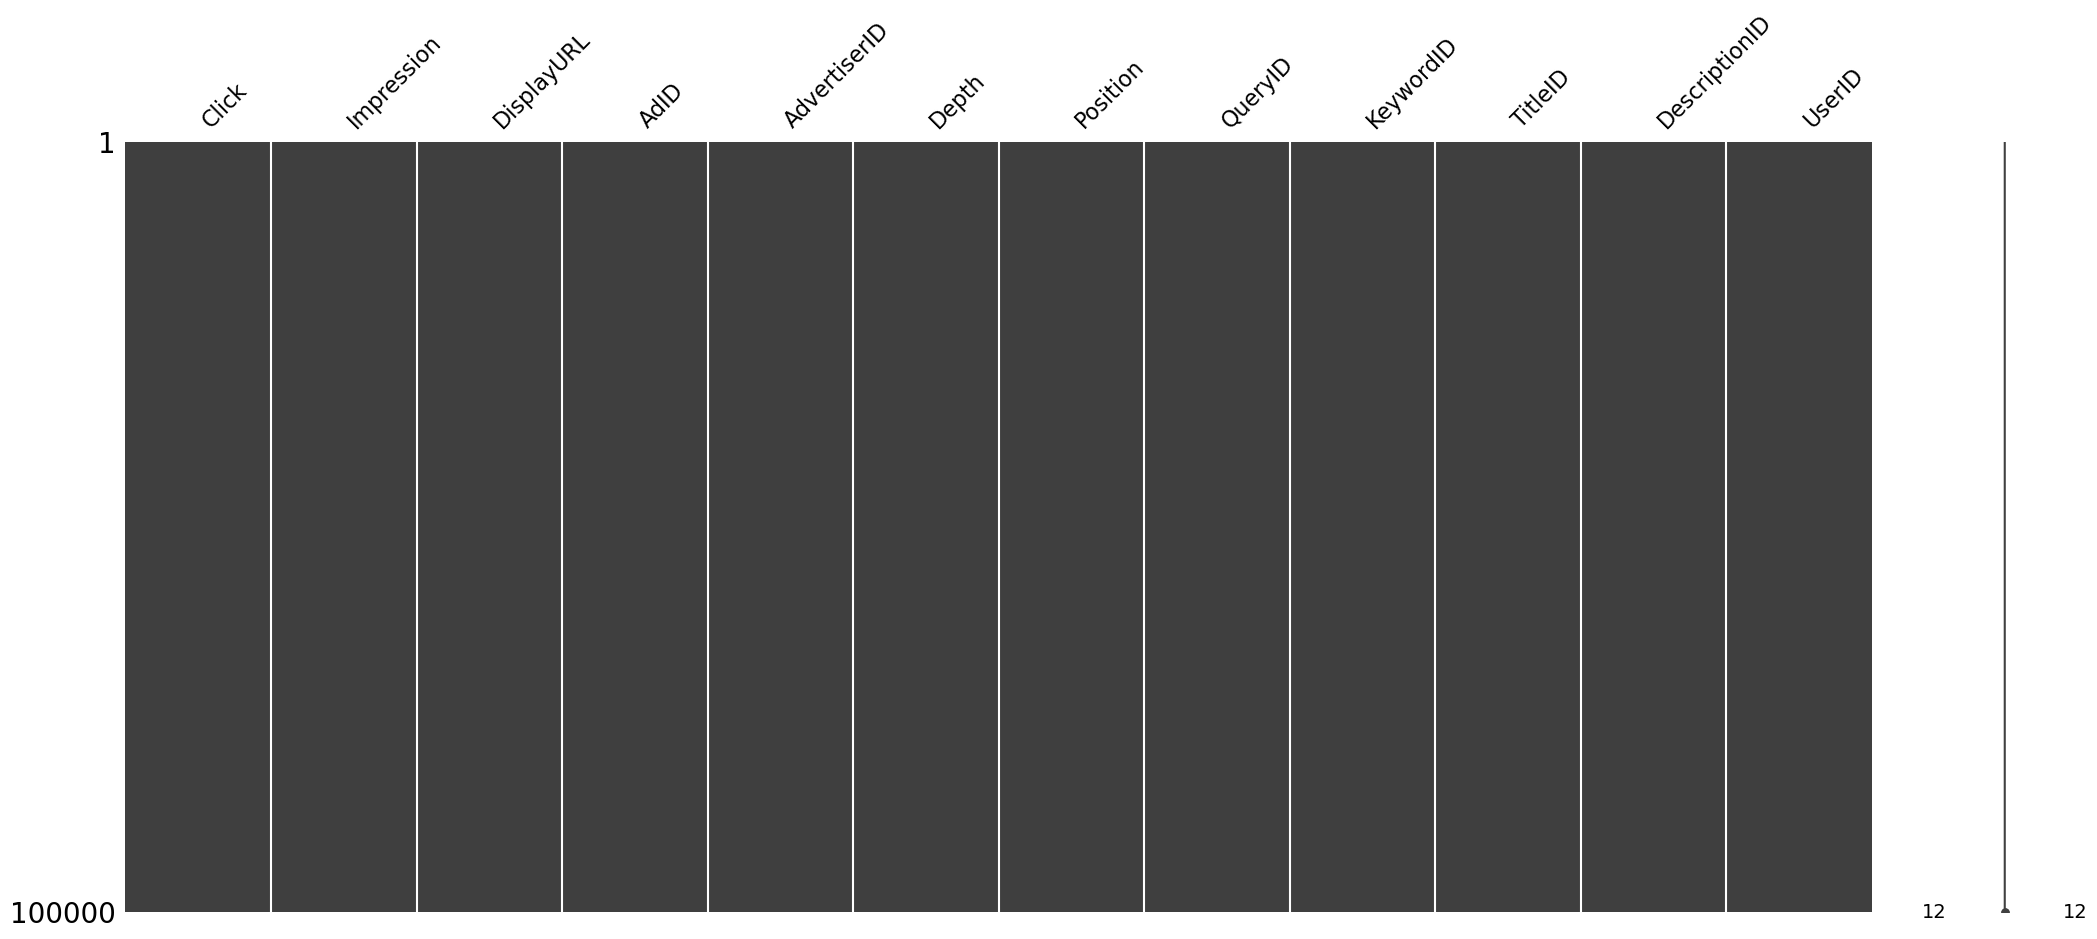

In [46]:
display_data_info('kdd12_training')

## Avazu

## Criteo

# Simulatinons

# Summary of findings

# Suggested Future Research

<a class="anchor" id="references"></a>
# References

<a class="anchor" id="eMarketer"></a>
* eMarketer. (2023). Digital advertising spending worldwide from 2021 to 2027 (in billion U.S. dollars) . Statista. Statista Inc.. Accessed: June 09, 2024. https://www-statista-com.iclibezp1.cc.ic.ac.uk/statistics/237974/online-advertising-spending-worldwide/

<a class="anchor" id="kdd12"></a>
* Aden, Yi Wang. (2012). KDD Cup 2012, Track 2. Kaggle. https://kaggle.com/competitions/kddcup2012-track2

<a class="anchor" id="avazu"></a>
* Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction

<a class="anchor" id="criteo"></a>
* Jean-Baptiste Tien, joycenv, Olivier Chapelle. (2014). Display Advertising Challenge. Kaggle. https://kaggle.com/competitions/criteo-display-ad-challenge